# Single predictor models
Single predictor models investigating the effect of a range of lower- and higher-level visual and auditory predictors. Analyses are run using Neuroscout's pyNS interaface for the Neuroscout API. Identical analyses are specified for each dataset / task combination. 

In [82]:
from collections import defaultdict
from pyns import Neuroscout
from pathlib import Path
from create import create_single_models

import sys
sys.path.append("..") 
from utils import dump_collection, load_collection

%matplotlib inline

<div class="alert alert-block alert-info">
<b>Note:</b> To push models to Neuroscout, authenticate pyNS by setting `NEUROSCOUT_USER` and `NEUROSCOUT_PASSWORD` environment variables, or directly passing your auth details to `Neuroscout()`. Google SSO logins are not currently supported.
</div>

In [2]:
api = Neuroscout()

## Define predictors and confounds

In [3]:
predictors = ['speech', 'rms', 'text', 'brightness', 'shot_change', 'landscape', 'building', 'tool']
confounds = [
    'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 
    'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'
]
datasets = api.datasets.get() # Get all Neuroscout datasets

## Create models

The following will create a neuroscout analysis for every dataset/task that and predictor combination. 

<div class="alert alert-block alert-info">
<b>Note:</b> If a predictor is unavailable for a task, it will be skipped. Examples include visual predictor for auditory narratives, and "shot_change" for NNDb, due to issues with large stimuli in their API
</div>

Uncomment the follwing line to re-execute and re-create models for the logged in acccount.

In [4]:
# single_models = create_single_models(predictors, confounds, datasets)

In [5]:
filename = Path('models') / 'single_predictor.json'

In [6]:
# Save models out to disk:
# dump_collection(single_mdoels, filename)

In [7]:
# Load models from cache
single_models = load_collection(filename)

In [25]:
# Three models for "building" Clarifai visual predictor
single_models['building'][0:3]

[{'dataset': 'Budapest',
  'task': 'movie',
  'hash_id': 'A13DD',
  'analysis': <Analysis hash_id=A13DD name=building dataset_id=27>},
 {'dataset': 'HealthyBrainNetwork',
  'task': 'movieDM',
  'hash_id': 'w0vov',
  'analysis': <Analysis hash_id=w0vov name=building dataset_id=8>},
 {'dataset': 'LearningTemporalStructure',
  'task': 'movie',
  'hash_id': 'AVrDK',
  'analysis': <Analysis hash_id=AVrDK name=building dataset_id=19>}]

We can inspect the BIDS StatsModel generate for any analysis. 

For example: `building` for the `Budapest` dataset:

In [73]:
# BIDS StatsModel generated for a single analysis. 
# In this case, "studyforrest" for the "building" feature
single_models['building'][-1]['analysis'].model

{'Input': {'Run': [1, 2, 3, 4, 5, 6, 7, 8],
  'Subject': ['10',
   '19',
   '04',
   '03',
   '01',
   '18',
   '15',
   '09',
   '16',
   '14',
   '05',
   '20',
   '06'],
  'Task': 'movie'},
 'Name': 'building',
 'Steps': [{'Contrasts': [],
   'DummyContrasts': {'Conditions': ['building'], 'Type': 't'},
   'Level': 'Run',
   'Model': {'X': ['a_comp_cor_00',
     'a_comp_cor_01',
     'a_comp_cor_02',
     'a_comp_cor_03',
     'a_comp_cor_04',
     'a_comp_cor_05',
     'trans_x',
     'trans_y',
     'trans_z',
     'rot_x',
     'rot_y',
     'rot_z',
     'building']},
   'Transformations': [{'Input': ['building'], 'Name': 'Convolve'}]},
  {'DummyContrasts': {'Type': 'FEMA'}, 'Level': 'Subject'},
  {'DummyContrasts': {'Type': 't'}, 'Level': 'Dataset'}]}

## Generate reports

For every individual analysis created, we can generate reports to inspect the design matrix

In [19]:
analysis = single_models['building'][0]['analysis']
analysis.generate_report(run_id=analysis.runs[0]) # Only generate for a single example run, to save time

{'generated_at': '2022-03-24T21:5',
 'result': None,
 'sampling_rate': None,
 'scale': False,
 'status': 'PENDING',
 'traceback': None,
 'warnings': []}

In [26]:
analysis.plot_report(plot_type='design_matrix_plot')

In [27]:
analysis.plot_report(plot_type='design_matrix_corrplot')

## Compile models

The following will "compile" every created model, validating the model and producing an executable bundle 

In [12]:
for pred, models in single_models.items():
    for model in models:
        # If analysis is still in "DRAFT" model, compile it.
        if model['analysis'].get_status()['status'] == 'DRAFT':
            model['analysis'].compile()

## Model Execution

Models can be executed using Neuroscout-CLI. For more information see the [Neuroscout documentation](https://neuroscout.github.io/neuroscout/cli/).

For example, to re-run the following model using Docker:

In [22]:
single_models['building'][0]

{'dataset': 'Budapest',
 'task': 'movie',
 'hash_id': 'A13DD',
 'analysis': <Analysis hash_id=A13DD name=building dataset_id=27>}

Use the following command:

```
docker run --rm -it -v /home/results/:/out neuroscout/neuroscout-cli run --force-upload A13DD /out
```

This will download the bundle for `M8LYl`, the necessary preprocessed imaging data from the `Budapest` dataset, run the analysis workflow and upload results to NeuroVault (even if an upload already exists).

<div class="alert alert-block alert-info">
<b>Note:</b> Replace `/home/results` with a real directory in your local environment
</div>


# Results

All results are indexed by Neuroscout after execution, and the resulting statistical images are archived in NeuroVault. 

Let's take a look at a single analysis as an example: `"building"` feature for the `"Budapest"` datsaetg

In [74]:
single_models['building'][0]

{'dataset': 'Budapest',
 'task': 'movie',
 'hash_id': 'A13DD',
 'analysis': <Analysis hash_id=A13DD name=building dataset_id=27>}

In [76]:
analysis = single_models['building'][0]['analysis']
analysis

<Analysis hash_id=A13DD name=building dataset_id=27>

We can view this analysis and the associated uploads interactively using Neuroscout's website at this URL: https://neuroscout.org/builder/A13DD

Alternatively, we can download the associated images and display them like here using the Python tools. 

The following will download the images matching `image_filters` for the latest associated NeuroVault collection and plot the results using `nilearn.plotting`

In [ ]:
DOWNLOAD_DIR = Path('./images')

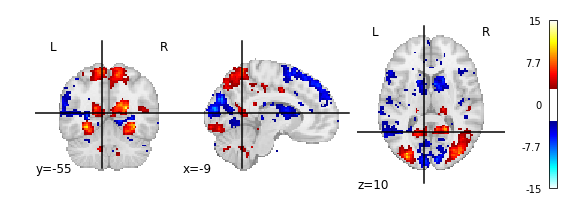

In [72]:
analysis.plot_uploads(download_dir=DOWNLOAD_DIR, 
                      image_filters={'stat': 't', 'space': 'MNI152NLin2009cAsym'}, 
                      plot_args={'threshold':3})

### Figure 4
In Figure 4, we display three features: `building`, `text`, and `rms` for for datasets/tasks: `Sherlock/SherlockMovie`, `LearningTemporalStructure/movie`, `NaturalisticNeuroimagingDatabase/500daysofsummer` and `studyforrest/movies`. 

We convert the group level t maps to z maps, threshold at p<0.001, and and plot using nilearn on a grid

In [69]:
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from tools.utils import t_to_z

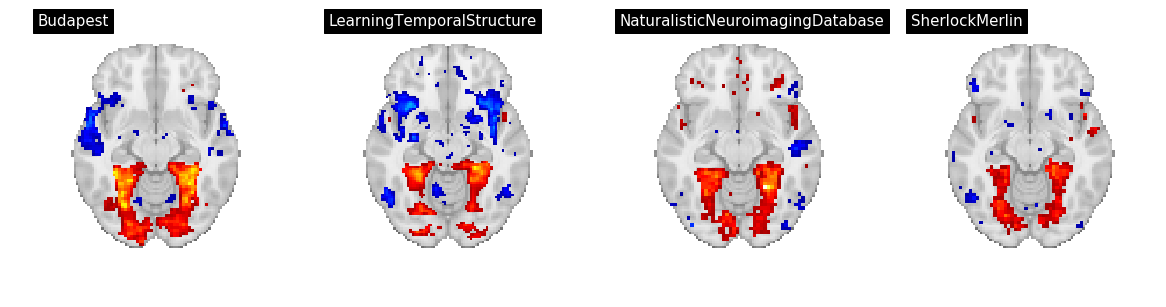

In [79]:
plot_args = dict(colorbar=False, display_mode='z', cut_coords=[-12], vmax=15, annotate=False)
contrast = 'building'

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))

i = 0
for an in single_models[contrast]:
    # Only plot for 4 tasks
    if an['task'] in ['SherlockMovie', 'movie', '500daysofsummer'] and an['dataset'] not in ['studyforrest']:
        ax = axs[i]
        i += 1
        # Download images matching filters
        t_map, metadata = an['analysis'].load_uploads(
                image_filters={'stat': 't', 'space': 'MNI152NLin2009cAsym'}, 
                download_dir=DOWNLOAD_DIR)[0]
        
        # Convert to Z maps, and compute threshold at p<0.001
        n_subjects = len(an['analysis'].model['Input']['Subject'])
        z_map = t_to_z(t_map, n_subjects-1)
        thresh_z_map, thresh = threshold_stats_img(z_map, alpha=0.001)
        
        # Plot
        plot_stat_map(thresh_z_map, threshold=thresh, title=f"{an['dataset']}", **plot_args, axes=ax)

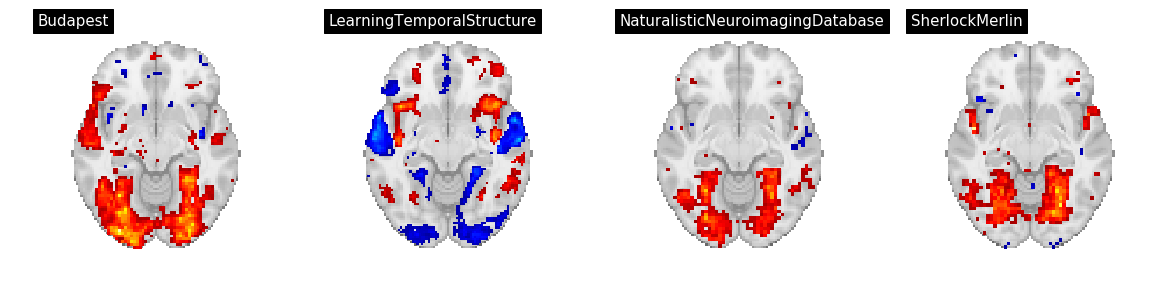

In [78]:
plot_args = dict(colorbar=False, display_mode='z', cut_coords=[-10], vmax=15, annotate=False)
contrast = 'text'
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))

i = 0

for an in single_models[contrast]:
    if an['task'] in ['SherlockMovie', 'movie', '500daysofsummer'] and an['dataset'] not in ['studyforrest']:
        ax = axs[i]
        i += 1
        t_map, metadata = an['analysis'].load_uploads(
                image_filters={'stat': 't', 'space': 'MNI152NLin2009cAsym'}, 
                download_dir=DOWNLOAD_DIR)[0]
        n_subjects = len(an['analysis'].model['Input']['Subject'])
        z_map = t_to_z(t_map, n_subjects-1)
        thresh_z_map, thresh = threshold_stats_img(z_map, alpha=0.001)
        plot_stat_map(thresh_z_map, threshold=thresh, **plot_args, title=f"{an['dataset']}", axes=ax)

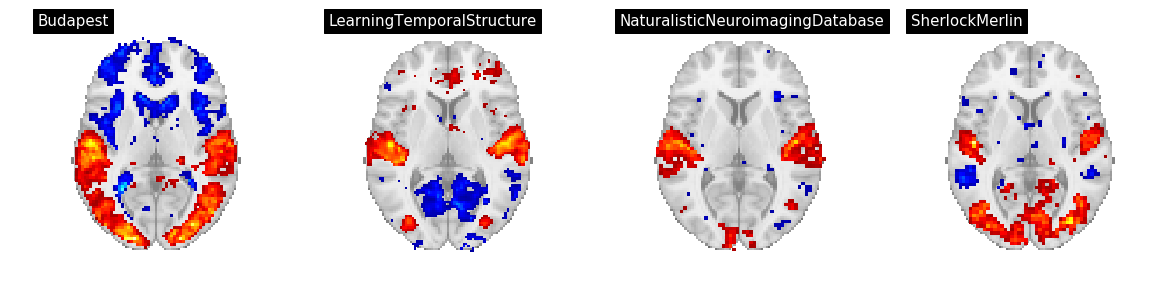

In [77]:
plot_args = dict(colorbar=False, display_mode='z', cut_coords=[6], vmax=15, annotate=False)
contrast = 'rms'
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))

i = 0

for an in single_models[contrast]:
    if an['task'] in ['SherlockMovie', 'movie', '500daysofsummer'] and an['dataset'] not in ['studyforrest']:
        ax = axs[i]
        i += 1
        t_map, metadata = an['analysis'].load_uploads(
                image_filters={'stat': 't', 'space': 'MNI152NLin2009cAsym'}, 
                download_dir=DOWNLOAD_DIR)[0]
        n_subjects = len(an['analysis'].model['Input']['Subject'])
        z_map = t_to_z(t_map, n_subjects-1)
        thresh_z_map, thresh = threshold_stats_img(z_map, alpha=0.001)
        plot_stat_map(thresh_z_map, threshold=thresh, **plot_args, title=f"{an['dataset']}", axes=ax)